In [282]:
# loadings and defaults
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import repackage

import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker

%config InlineBackend.figure_format='png'



In [283]:
# my functions



def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})
    print('done renaming')
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])
    print('made grid object')

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta.mean(dim="ocean_time") + ds.zice + (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta.mean(dim="ocean_time") + ds.zice + ds.h) + ds.zeta.mean(dim="ocean_time") + ds.zice

    print('done making vertical coords')

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('s_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('s_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')
    print('done interpolation of depths')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)
    print('done interpolation of x,y')

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy
    print('made metrics')

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    print('assigned metrics')
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [284]:
norm = xr.open_dataset('/Users/dave/Documents/dave/Projects/totten_sgfw/tisom017_sgfw/data/proc/tisom_his_0021_trimmed.nc')
gridFile=xr.open_dataset('/Users/dave/Documents/dave/Projects/totten_sgfw/tisom017_sgfw/data/raw/tisom008_canal_grd.nc')
mask_zice = (norm.zice<0)
mask_zice_nan = mask_zice.where(mask_zice!=0.0,np.nan)

norm = processROMSGrid(norm)

norm['x_rho']=gridFile.x_rho
norm['y_rho']=gridFile.y_rho
norm = norm.set_coords(['x_rho','y_rho'])
# norm.ocean_time.values

noflow = xr.open_dataset('/Users/dave/Documents/dave/Projects/totten_sgfw/tisom017_sgfw/data/proc/tisom_his_0021_NoFlow.nc')
noflow = processROMSGrid(noflow)
noflow['x_rho']=gridFile.x_rho
noflow['y_rho']=gridFile.y_rho
noflow = noflow.set_coords(['x_rho','y_rho'])
# noflow.ocean_time.values

done renaming
made grid object
done making vertical coords
done interpolation of depths
done interpolation of x,y
made metrics
assigned metrics
done renaming
made grid object
done making vertical coords
done interpolation of depths
done interpolation of x,y
made metrics
assigned metrics


<ipython-input-285-744357ae81fe>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,((norm.m*365*60*60*24).mean(dim='ocean_time')-(noflow.m*365*60*60*24).mean(dim='ocean_time'))/(noflow.m*365*60*60*24).mean(dim='ocean_time')*100,vmin=-10,vmax=10,cmap='cmo.balance')


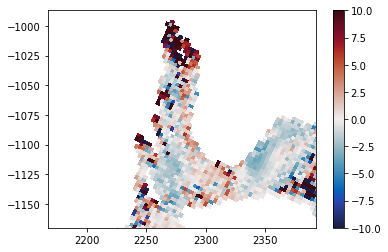

In [285]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,((norm.m*365*60*60*24).mean(dim='ocean_time')-(noflow.m*365*60*60*24).mean(dim='ocean_time'))/(noflow.m*365*60*60*24).mean(dim='ocean_time')*100,vmin=-10,vmax=10,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


<ipython-input-267-3d670a4d1857>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=-1).mean(dim='ocean_time')-noflow.temp.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')


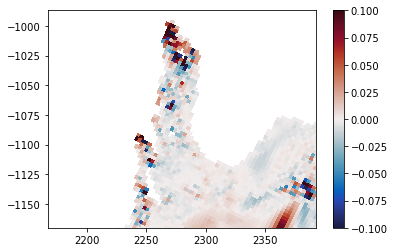

In [267]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.temp.isel(s_rho=-1).mean(dim='ocean_time')-noflow.temp.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


<ipython-input-268-3f0abf0b1197>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.salt.isel(s_rho=-1).mean(dim='ocean_time')-noflow.salt.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')


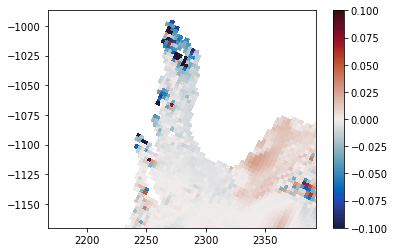

In [268]:
im=plt.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,norm.salt.isel(s_rho=-1).mean(dim='ocean_time')-noflow.salt.isel(s_rho=-1).mean(dim='ocean_time'),vmin=-.1,vmax=.1,cmap='cmo.balance')
plt.axis('equal')
plt.xlim([2.240e3,2.32e3])
plt.ylim([-1.170e3,-.987e3])
plt.colorbar(im)


In [269]:
norm

<xarray.Dataset>
Dimensions:        (boundary: 4, eta_rho: 260, eta_v: 259, ocean_time: 365, s_rho: 31, s_w: 32, tracer: 3, xi_rho: 381, xi_u: 380)
Coordinates: (12/15)
    lat_psi        (eta_v, xi_u) float64 ...
    lat_rho        (eta_rho, xi_rho) float64 -67.59 -67.59 ... -60.02 -60.02
    lat_u          (eta_rho, xi_u) float64 ...
    lat_v          (eta_v, xi_rho) float64 ...
    lon_psi        (eta_v, xi_u) float64 ...
    lon_rho        (eta_rho, xi_rho) float64 104.6 104.7 104.7 ... 129.9 129.9
    ...             ...
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    z_w            (s_w, eta_rho, xi_rho) float64 0.0 0.0 ... -0.03696 -0.03696
    z_rho          (s_rho, eta_rho, xi_rho) float64 0.0 0.0 ... -0.8846 -0.8846
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
Dimensions without coordinates: boundary, eta_rho, eta_v, tracer, xi_rho, xi_u
Data variables: (12/94)
    Akt_bak        (tracer) float64 ...
    Akv_bak        float64 ...
    Cs_r           (s_rho) float64 ...
    Cs_w           (s_w) float64 ...
    FSobc_in       (boundary) float64 ...
    FSobc_out      (boundary) float64 ...
    ...             ...
    dz_w           (s_w, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dz_u           (s_rho, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_u         (s_w, eta_rho, xi_u) float64 0.0 0.0 0.0 ... 0.8834 0.8846
    dz_v           (s_rho, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 2.75 2.75 2.75
    dz_w_v         (s_w, eta_v, xi_rho) float64 0.0 0.0 0.0 ... 0.8846 0.8846
    dA             (eta_rho, xi_rho) float64 8.218e+06 8.218e+06 ... 1.5e+07
Attributes: (12/28)
    file:              tisom_his_0021.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4
    type:              ROMS/TOMS history file
    title:             Totten Ice Shelf/Ocean Application
    rst_file:          tisom_rst.nc
    ...                ...
    compiler_flags:    -heap-arrays -fp-model precise -ip -O3 -free -free
    tiling:            016x018
    history:           Mon Nov  1 10:51:43 2021: ncks -O -x -v sustr,svstr,ss...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       TOTTEN_SGFW, ADD_FSOBC, ANA_BPFLUX, ANA_BSFLUX, ANA_BT...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

<ipython-input-270-1ab3797bff40>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


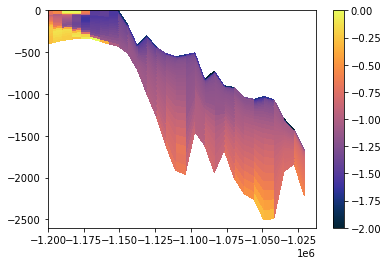

In [270]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['x_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')

yy = grid.transform(norm.y_rho, 'X', np.array([2.285e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

Y = yy.squeeze().fillna(-3e6)

plt.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
plt.xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
plt.ylim([-2600,0])
plt.colorbar()

<ipython-input-271-57ca57dda654>:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


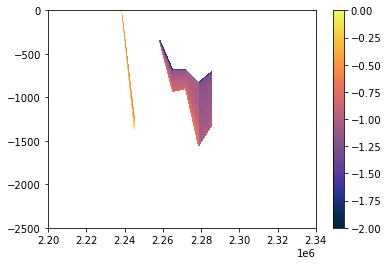

In [271]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['y_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')

xx = grid.transform(norm.x_rho, 'Y', np.array([-1.095e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)

X = xx.squeeze().fillna(-3e6)

plt.pcolormesh(X,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
plt.xlim([2.200e6,2.340e6])
plt.ylim([-2500,0])
plt.colorbar()

(10.0, 30.0)

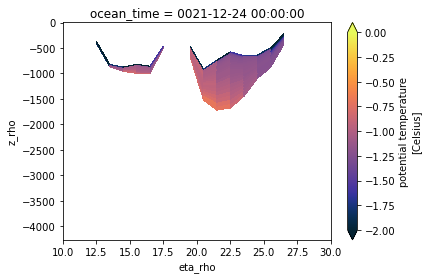

In [272]:
norm.temp.isel(ocean_time=360,xi_rho=165).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([10,30])


(140.0, 170.0)

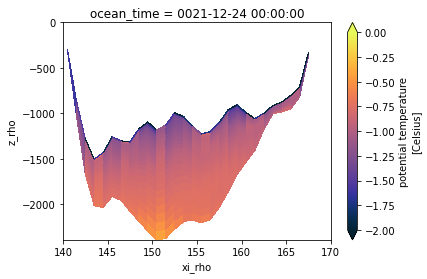

In [273]:
norm.temp.isel(ocean_time=360,eta_rho=15).plot(y='z_rho',vmin=-2,vmax=0, cmap='cmo.thermal')
plt.xlim([140,170])

# NOW HONE EACH SUB PLOT INDIVIDUALLY

<ipython-input-274-47485a06a26c>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


<Figure size 432x288 with 0 Axes>

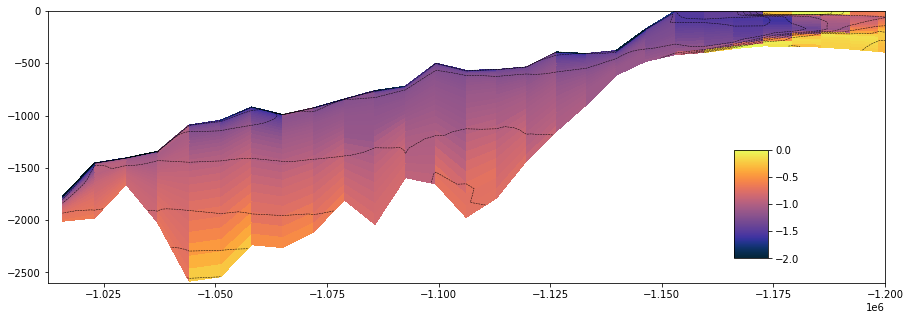

In [274]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['x_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')

yy = grid.transform(norm.y_rho, 'X', np.array([2.284e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)
Y = np.tile(yy.squeeze().fillna(-3e6),[31,1])





gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(Y,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(Y,Z,temp_500m.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()

<ipython-input-275-581a2ee2ec07>:34: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(X/1e3,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')


<Figure size 432x288 with 0 Axes>

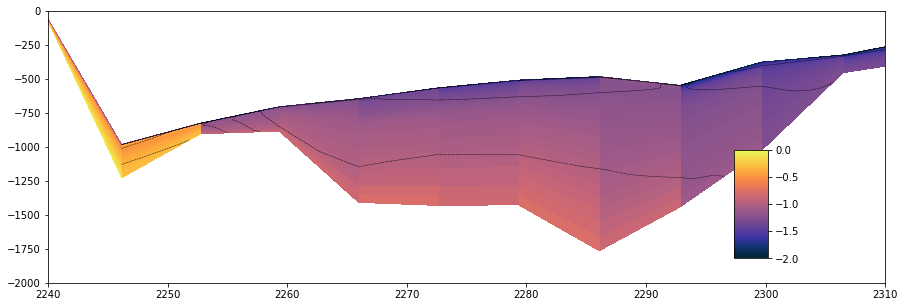

In [275]:
grid = makeROMSGridObject(norm)
depth_snapshot = norm['y_rho']
temp_500m = grid.transform(norm.temp.isel(ocean_time=360), 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')

temp_500m#.isel(x_rho=0).plot(x='eta_rho',y='z_rho')


zz = grid.transform(norm.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')

xx = grid.transform(norm.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=depth_snapshot,
                                method='linear')



Z = zz.squeeze().fillna(20)
X = np.tile(xx.squeeze().fillna(-3e6),[31,1])





gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(X/1e3,Z,temp_500m.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(X/1e3,Z,temp_500m.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2000,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)


In [276]:
X

array([[-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.],
       [-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.],
       [-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.],
       ...,
       [-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.],
       [-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.],
       [-3000000., -3000000., -3000000., ..., -3000000., -3000000.,
        -3000000.]])

<ipython-input-277-21e22a9faac8>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)


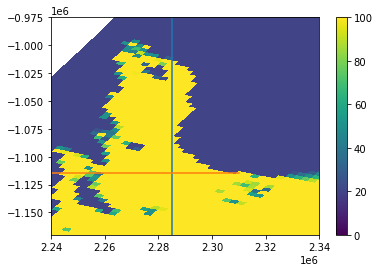

In [277]:
plt.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)
plt.xlim([2.240e6,2.340e6])
plt.ylim([-1.170e6,-.975e6])
plt.colorbar()
plt.plot([2.285e6,2.285e6],[-1.2e6,-.975e6])
plt.plot([2.24e6,2.31e6],[-1.115e6,-1.115e6])


In [278]:
grid = makeROMSGridObject(norm)

norm_depth_snapshot_1 = norm['y_rho']
norm_temp_1 = grid.transform(norm.temp.mean(dim='ocean_time'), 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')


norm_zz_1 = grid.transform(norm.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')

norm_xx_1 = grid.transform(norm.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=norm_depth_snapshot_1,
                                method='linear')



norm_Z_1 = norm_zz_1.squeeze().fillna(20)
norm_X_1 = np.tile(norm_xx_1.squeeze().fillna(-3e6),[31,1])



norm_depth_snapshot_2 = norm['x_rho']
norm_temp_2 = grid.transform(norm.temp.mean(dim='ocean_time'), 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')


norm_zz_2 = grid.transform(norm.z_rho, 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')

norm_yy_2 = grid.transform(norm.y_rho, 'X', np.array([2.284e6]),
                                target_data=norm_depth_snapshot_2,
                                method='linear')



norm_Z_2 = norm_zz_2.squeeze().fillna(20)
norm_Y_2 = np.tile(norm_yy_2.squeeze().fillna(-3e6),[31,1])

In [279]:
grid = makeROMSGridObject(noflow)

noflow_depth_snapshot_1 = noflow['y_rho']
noflow_temp_1 = grid.transform(noflow.temp.mean(dim='ocean_time'), 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')


noflow_zz_1 = grid.transform(noflow.z_rho, 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')

noflow_xx_1 = grid.transform(noflow.x_rho, 'Y', np.array([-1.115e6]),
                                target_data=noflow_depth_snapshot_1,
                                method='linear')



noflow_Z_1 = noflow_zz_1.squeeze().fillna(20)
noflow_X_1 = np.tile(noflow_xx_1.squeeze().fillna(-3e6),[31,1])



noflow_depth_snapshot_2 = noflow['x_rho']
noflow_temp_2 = grid.transform(noflow.temp.mean(dim='ocean_time'), 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')


noflow_zz_2 = grid.transform(noflow.z_rho, 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')

noflow_yy_2 = grid.transform(noflow.y_rho, 'X', np.array([2.284e6]),
                                target_data=noflow_depth_snapshot_2,
                                method='linear')



noflow_Z_2 = noflow_zz_2.squeeze().fillna(20)
noflow_Y_2 = np.tile(noflow_yy_2.squeeze().fillna(-3e6),[31,1])

<ipython-input-288-53fe375c4d8a>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-1.2,vmax=-.8,cmap='cmo.thermal')
<ipython-input-288-53fe375c4d8a>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
<ipython-input-288-53fe375c4d8a>:42: MatplotlibDeprecationWarning: shading='flat' when X and

<Figure size 432x288 with 0 Axes>

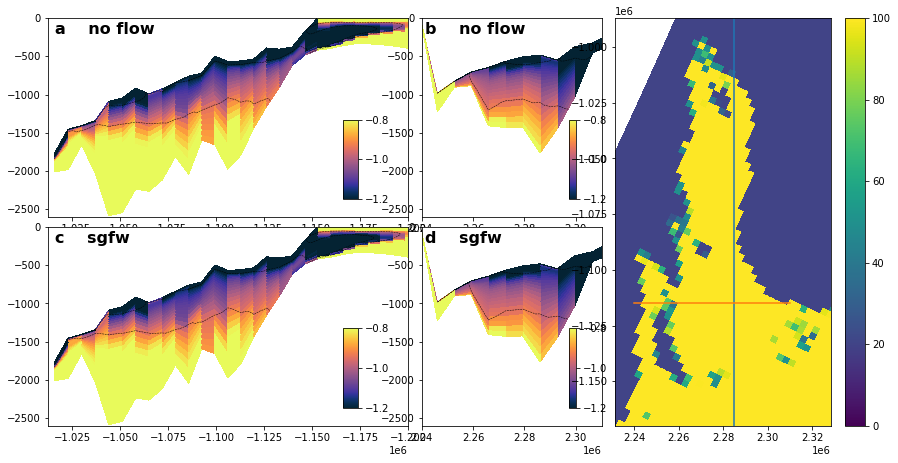

In [288]:


gs = gridspec.GridSpec(nrows=2,ncols=3,wspace=0.05, hspace=0.05,width_ratios=[2, 1, 1.5])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7.5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-1.2,vmax=-.8,cmap='cmo.thermal')
co=ax.contour(noflow_Y_2,noflow_Z_2,noflow_temp_2.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.text(0.02, 0.98, 'a    no flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])
im=ax.pcolormesh(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(noflow_X_1,noflow_Z_1,noflow_temp_1.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6,2.310e6])
plt.ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.text(0.02, 0.98, 'b    no flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
im=ax.pcolormesh(norm_Y_2,norm_Z_2,norm_temp_2.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(norm_Y_2,norm_Z_2,norm_temp_2.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.20e6,-1.0125e6])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.text(0.02, 0.98, 'c    sgfw', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,1])
im=ax.pcolormesh(norm_X_1,norm_Z_1,norm_temp_1.squeeze(),vmin=-1.2,vmax=-0.8,cmap='cmo.thermal')
co=ax.contour(norm_X_1,norm_Z_1,norm_temp_1.squeeze(),levels=np.arange(-1.2,-0.8,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6,2.310e6])
plt.ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
ax.text(0.02, 0.98, 'd    sgfw', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')


ax=fig.add_subplot(gs[0:2,2])
im = ax.pcolormesh(gridFile.x_rho,gridFile.y_rho,gridFile.h+gridFile.zice,vmin=0,vmax=100)
ax.axis('equal')
ax.set_xlim([2.240e6,2.32e6])
ax.set_ylim([-1.170e6,-.987e6])
fig.colorbar(im)
plt.plot([2.285e6,2.285e6],[-1.2e6,-.975e6])
plt.plot([2.24e6,2.31e6],[-1.115e6,-1.115e6])


<ipython-input-281-3aa16cad15de>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_Y_2/1e3,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
<ipython-input-281-3aa16cad15de>:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=ax.pcolormesh(noflow_X_1/1e3,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
<ipython-input-281-3aa16cad15de>:46: MatplotlibDeprecationWarning: shading='flat' when X and 

Text(0.75, 0.33, ' B   ')

<Figure size 432x288 with 0 Axes>

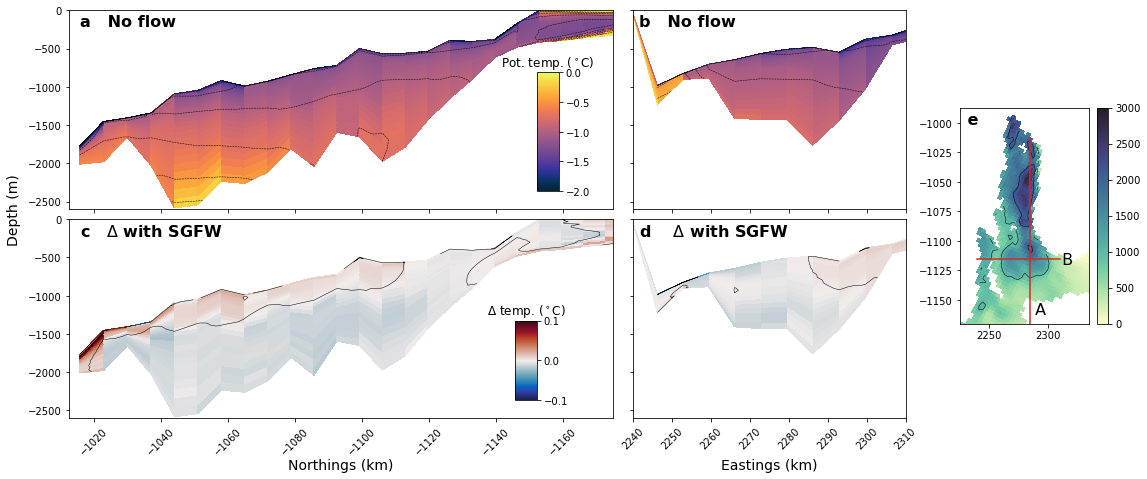

In [281]:


gs = gridspec.GridSpec(nrows=2,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[2, 1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7.5])
ax = None

ax=fig.add_subplot(gs[0,0])
im=ax.pcolormesh(noflow_Y_2/1e3,noflow_Z_2,noflow_temp_2.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(noflow_Y_2/1e3,noflow_Z_2,noflow_temp_2.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
ax.set_xlim([-1.175e6/1e3,-1.0125e6/1e3])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="75%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.86,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cax.set_title('Pot. temp. ($^\circ$C)')
fig.colorbar(im,cax=cax)
ax.invert_xaxis()
ax.set_xticklabels([])
ax.text(0.02, 0.98, 'a   No flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[0,1])
im=ax.pcolormesh(noflow_X_1/1e3,noflow_Z_1,noflow_temp_1.squeeze(),vmin=-2,vmax=0,cmap='cmo.thermal')
co=ax.contour(noflow_X_1/1e3,noflow_Z_1,noflow_temp_1.squeeze(),levels=np.arange(-2,0,.25),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2600,0])
# cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.82,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# fig.colorbar(im,cax=cax)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(0.02, 0.98, 'b   No flow', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,0])
im=ax.pcolormesh(norm_Y_2/1e3,norm_Z_2,norm_temp_2.squeeze()-noflow_temp_2.squeeze(),vmin=-.1,vmax=0.1,cmap='cmo.balance')
co=ax.contour(norm_Y_2/1e3,norm_Z_2,norm_temp_2.squeeze()-noflow_temp_2.squeeze(),levels=np.arange(-.1,.1,.05),colors='k',linewidths=0.5)
ax.set_xlim([-1.175e6/1e3,-1.0125e6/1e3])
#plt.xlim([-1.50e6,-.975e6])
ax.set_ylim([-2600,0])
cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.82,.09, .8, .8),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
fig.colorbar(im,cax=cax)
cax.set_title('$\Delta$ temp. ($^\circ$C)')
ax.invert_xaxis()
ax.text(0.5, -0.2, 'Northings (km)',fontsize=14, va='top', ha='center', transform=ax.transAxes)
ax.text(-.1, 1.05, 'Depth (m)',fontsize=14, va='center', ha='center', rotation='vertical', transform=ax.transAxes)
ax.tick_params('x',labelrotation=45)
ax.text(0.02, 0.98, 'c   $\Delta$ with SGFW', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')

ax=fig.add_subplot(gs[1,1])
im=ax.pcolormesh(norm_X_1/1e3,norm_Z_1,norm_temp_1.squeeze()-noflow_temp_1.squeeze(),vmax=.1,vmin=-.1,cmap='cmo.balance')
co=ax.contour(norm_X_1/1e3,norm_Z_1,norm_temp_1.squeeze()-noflow_temp_1.squeeze(),levels=np.arange(-.1,.1,.05),colors='k',linewidths=0.5)
plt.xlim([2.2400e6/1e3,2.310e6/1e3])
plt.ylim([-2600,0])
# cax = inset_axes(ax,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="50%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(.82,.09, .8, .8),
#                  bbox_transform=ax.transAxes,
#                  borderpad=0,
#                  )
# fig.colorbar(im,cax=cax)
ax.set_yticklabels([])
ax.text(0.5, -0.2, 'Eastings (km)',fontsize=14, va='top', ha='center', transform=ax.transAxes)
ax.tick_params(labelrotation=45)
ax.text(0.02, 0.98, 'd    $\Delta$ with SGFW', transform=ax.transAxes,fontsize=16, fontweight='bold', va='top')



axins = fig.add_axes([.95, .3, 0.15, 0.4])
im = axins.pcolormesh(gridFile.x_rho/1000,gridFile.y_rho/1000,gridFile.h.where(norm.zice!=0,np.nan),vmin=0,vmax=3000,cmap='cmo.deep',shading='nearest')
co = axins.contour(gridFile.x_rho/1000,gridFile.y_rho/1000,gridFile.h.where(norm.zice!=0,np.nan),levels=[0,1000,2000,3000],colors='k',vmin=0,vmax=3000,linewidths=0.5)
axins.axis('equal')
axins.set_xlim([2.240e3,2.32e3])
axins.set_ylim([-1.170e3,-.987e3])
fig.colorbar(im)
plt.plot([2.285e3,2.285e3],[-1.175e3,-1.0125e3],color='C3')
plt.plot([2.24e3,2.31e3],[-1.115e3,-1.115e3],color='C3')
axins.text(0.02, 0.98, ' e   ', transform=axins.transAxes,fontsize=16, fontweight='bold', va='top')
axins.text(0.54, 0.1, ' A   ', transform=axins.transAxes,fontsize=16, va='top')
axins.text(0.75, 0.33, ' B   ', transform=axins.transAxes,fontsize=16, va='top')
